## Capstone Project - The Battle of Neighborhoods

Introduction

New York (NY), is the most populous city in the United States. With an estimated 2018 population of 8,398,748 distributed over a land area of about 302.6 square miles.Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.
As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world.

With it's diverse culture , comes diverse food items. There are many resturants in New york City, each beloning to different categories like Chinese , Indian , French etc.

The problem statement is to identify and visualize all major parts of New York City that contains indian resturants.(with limited set of test data,as we can access only limited data from foursquare per day)


Data

For this project we need the following data :

New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
Data source : https://cocl.us/new_york_dataset
Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.
Indian resturants in each neighborhood of new york city.
Data source : Fousquare API
Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only indian resturants.
GeoSpace data
Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.

Approach


Collect the new york city data from https://cocl.us/new_york_dataset
Using FourSquare API we will find all venues for each neighborhood.
Filter out all venues that are 
Indian Resturants.
Find rating , tips and like count for each Indian Resturants using FourSquare API.
Using rating for each resturant , we will sort that data.
Visualize the Ranking of neighborhoods using folium library(python)
Questions that can be asked using the above mentioned datasets
What is best location in New York City for Indian Cuisine ?
Which areas have potential Indian Resturant Market ?
Which all areas lack Indian Resturants ?
Which is the best place to stay if I prefer Indian Cuisine ?

 import the required libraries for python.

pandas and numpy for handling data.
request module for using FourSquare API.
geopy to get co-ordinates of City of New York.
folium to visualize the results on a map
In [206]:

conda install -c anaconda beautifulsoup4

In [2]:
!conda install -c conda-forge geopy --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         239 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0         conda-forge
    geopy:         1.20.0-py_0       conda-forge

The following p

In [3]:
import folium # map rendering library
from geopy.geocoders import Nominatim

In [4]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
#import geocoder
import os

from geopy.geocoders import Nominatim # convert an address into latitude and longit
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
print('Libraries imported.')

Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [5]:
def geo_location(address):
# get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 50 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [43]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=50
    CLIENT_ID = 'J5TLT4NAIJL2BM2W0XUOH3QIIHADWO02EVJF5GU3K3WX14CD' # your Foursquare ID
    CLIENT_SECRET = '3Z1RDHFJ1CS3GVNYO2G1O3111O1ZAAISJ0TDS1W003JRUN5S'
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [92]:
def get_venue_details(venue_id):
    #CLIENT_ID = os.environ['CLIENT_ID'] # your Foursquare ID
    #CLIENT_SECRET = os.environ['CLIENT_SECRET'] # your Foursquare Secret
    CLIENT_ID = 'OZNSZDTSIOL1JOGR2BOJMLQBSCV1GQEYQFU0C1XWW3DHHAHQ' # your Foursquare ID
    CLIENT_SECRET = 'C5DINZ0AKSXVYAIWQUKRUI40LHTLZE2VE2YOC4BY13JK1B55' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
        venue_id,
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [39]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [9]:
# get new york data
new_york_data=get_new_york_data()

In [10]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [11]:
new_york_data.shape

(306, 4)

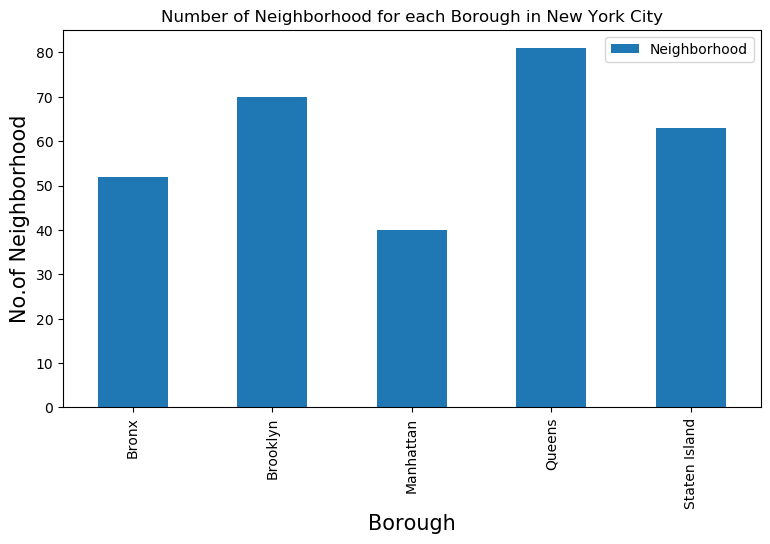

In [12]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods

Now we will collect Indian resturants for each Neighborhood

In [24]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    #print(venues)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

In [25]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
2,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
3,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill
4,Brooklyn,Brighton Beach,4af0d31bf964a5207ddf21e3,Pak Nasheman


In [26]:
indian_rest_ny.shape

(86, 4)

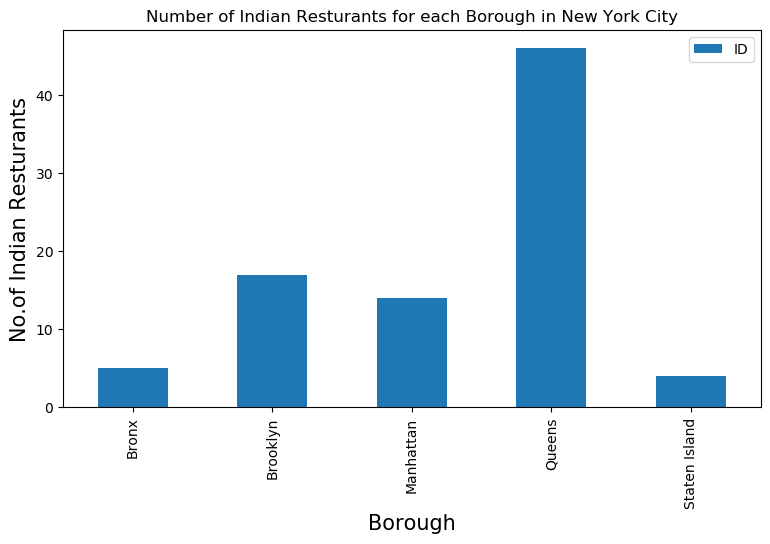

In [27]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has the largest number of indian resturants

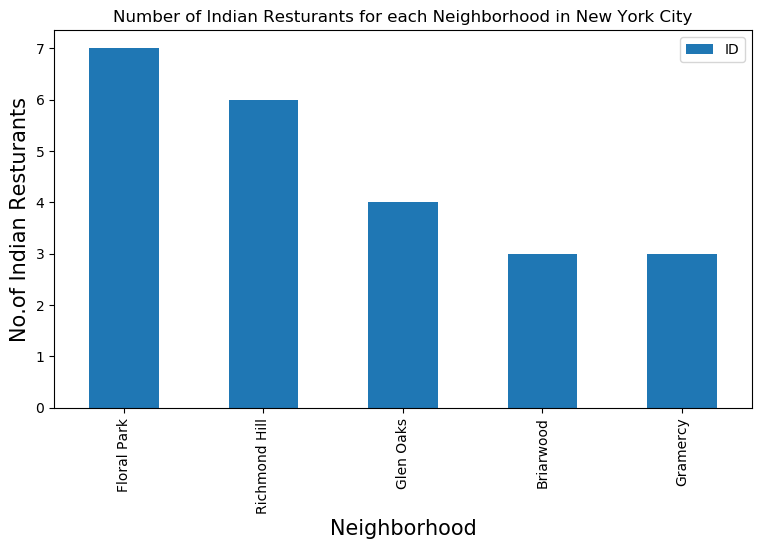

In [28]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [29]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
60,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
61,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
62,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
63,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
64,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
65,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
66,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese


So Floral Park in Queens has the highest number of Indian Resturants with a total count of 7

In [45]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5d4e67a622be120025a8f6fe'}, 'response': {}}


KeyError: 'venue'

This is a issue for foursquare dd quota_exceeded

### I got oly 51 records because of foursquare access limit

In [95]:
#temp_indian_rest_stats_ny=indian_rest_stats_ny
#temp_indian_rest_stats_ny.shape
#temp_indian_rest_stats=temp_indian_rest_stats_ny
#indian_rest_stats_ny=temp_indian_rest_stats

In [54]:
indian_rest_stats_ny.shape

(51, 7)

In [55]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,4,8.0,11
1,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.1,9
2,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.4,3
3,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
4,Brooklyn,Brighton Beach,4af0d31bf964a5207ddf21e3,Pak Nasheman,9,7.6,4


In [56]:
indian_rest_ny.shape

(86, 4)

In [57]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny1.csv', index=False)

In [58]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny1.csv')

In [59]:
indian_rest_stats_ny_csv.shape

(51, 7)

In [60]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,4,8.0,11
1,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.1,9
2,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.4,3
3,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
4,Brooklyn,Brighton Beach,4af0d31bf964a5207ddf21e3,Pak Nasheman,9,7.6,4


In [53]:
#indian_rest_stats_ny=indian_rest_stats_ny_csv

In [61]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 7 columns):
Borough         51 non-null object
Neighborhood    51 non-null object
ID              51 non-null object
Name            51 non-null object
Likes           51 non-null object
Rating          51 non-null float64
Tips            51 non-null object
dtypes: float64(1), object(6)
memory usage: 2.9+ KB


In [62]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,4,8.0,11
1,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.1,9
2,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.4,3
3,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
4,Brooklyn,Brighton Beach,4af0d31bf964a5207ddf21e3,Pak Nasheman,9,7.6,4


In [63]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')

In [64]:
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [65]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 7 columns):
Borough         51 non-null object
Neighborhood    51 non-null object
ID              51 non-null object
Name            51 non-null object
Likes           51 non-null float64
Rating          51 non-null float64
Tips            51 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


In [66]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                830
Rating                               8.8
Tips                                 257
Name: 23, dtype: object

In [67]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                           Queens
Neighborhood            Long Island City
ID              5b931ea69d7468002c3b1382
Name                                Adda
Likes                                 93
Rating                               9.1
Tips                                  25
Name: 42, dtype: object

In [68]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                830
Rating                               8.8
Tips                                 257
Name: 23, dtype: object

In [69]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [70]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
30,Sunnyside,9.100000
31,Tribeca,9.000000
0,Astoria,8.900000
20,Midtown,8.800000
13,Gramercy,8.733333
4,Chelsea,8.700000
28,South Side,8.700000
23,Prospect Lefferts Gardens,8.700000
21,North Side,8.700000
10,Fort Greene,8.600000


Above are the top neighborhoods with top average rating of Indian resturants

In [71]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [72]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.345455
1,Brooklyn,7.640000
3,Queens,7.228571
0,Bronx,6.950000


 these are the average rating of Indian Resturants for each Borough
 Note:Able to visualize only for few data(because of foursquare data limitation access per day)
 For more data Foursquare gives overquata limit per day

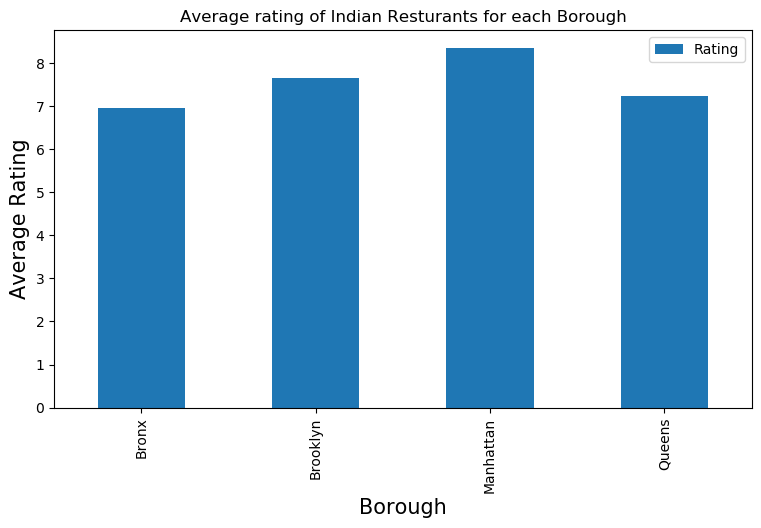

In [73]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 8.5 to visualize on map

In [74]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.5]

In [75]:
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Astoria,8.900000
4,Chelsea,8.700000
10,Fort Greene,8.600000
13,Gramercy,8.733333
20,Midtown,8.800000
21,North Side,8.700000
23,Prospect Lefferts Gardens,8.700000
28,South Side,8.700000
30,Sunnyside,9.100000
31,Tribeca,9.000000


In [76]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [77]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [78]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,8.900000
1,Manhattan,Chelsea,40.744035,-74.003116,8.700000
2,Staten Island,Chelsea,40.594726,-74.189560,8.700000
3,Brooklyn,Fort Greene,40.688527,-73.972906,8.600000
4,Manhattan,Gramercy,40.737210,-73.981376,8.733333
5,Manhattan,Midtown,40.754691,-73.981669,8.800000
6,Brooklyn,North Side,40.714823,-73.958809,8.700000
7,Brooklyn,Prospect Lefferts Gardens,40.658420,-73.954899,8.700000
8,Brooklyn,South Side,40.710861,-73.958001,8.700000
9,Queens,Sunnyside,40.740176,-73.926916,9.100000


In [79]:
ny_neighborhood_stats.sort_values(by='Average Rating', ascending=False)

,Borough,Neighborhood,Latitude,Longitude,Average Rating
9,Queens,Sunnyside,40.740176,-73.926916,9.100000
10,Staten Island,Sunnyside,40.612760,-74.097126,9.100000
11,Manhattan,Tribeca,40.721522,-74.010683,9.000000
0,Queens,Astoria,40.768509,-73.915654,8.900000
5,Manhattan,Midtown,40.754691,-73.981669,8.800000
4,Manhattan,Gramercy,40.737210,-73.981376,8.733333
1,Manhattan,Chelsea,40.744035,-74.003116,8.700000
2,Staten Island,Chelsea,40.594726,-74.189560,8.700000
6,Brooklyn,North Side,40.714823,-73.958809,8.700000
7,Brooklyn,Prospect Lefferts Gardens,40.658420,-73.954899,8.700000


In [80]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [81]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [82]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [83]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

### My Conclusion

#### Sunnyside(Staten Island),Sunnyside(Queens),Tribeca(Manhattan) are some of the best neighborhoods for indian cuisine.
#### Manhattan have potential Indian Resturant Market/
#### Manhattan is the best place to stay if you prefer Indian Cuisine.
#### It seems Staten Islan ranks last in average rating of Indian Resturants.

### Limitations¶
##### The ranking is purely on basis of rating of resturants
##### The accuracy of data depends purely depends on the data provided by FourSquare